In [5]:
import numpy as np
import torch
import time

from pytorch_pretrained_bert import (GPT2LMHeadModel, GPT2Tokenizer,
                                     BertTokenizer, BertForMaskedLM)


class AbstractLanguageChecker():
    """
    Abstract Class that defines the Backend API of GLTR.

    To extend the GLTR interface, you need to inherit this and
    fill in the defined functions.
    """

    def __init__(self):
        '''
        In the subclass, you need to load all necessary components
        for the other functions.
        Typically, this will comprise a tokenizer and a model.
        '''
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")

    def check_probabilities(self, in_text, topk=40):
        '''
        Function that GLTR interacts with to check the probabilities of words

        Params:
        - in_text: str -- The text that you want to check
        - topk: int -- Your desired truncation of the head of the distribution

        Output:
        - payload: dict -- The wrapper for results in this function, described below

        Payload values
        ==============
        bpe_strings: list of str -- Each individual token in the text
        real_topk: list of tuples -- (ranking, prob) of each token
        pred_topk: list of list of tuple -- (word, prob) for all topk
        '''
        raise NotImplementedError

    def postprocess(self, token):
        """
        clean up the tokens from any special chars and encode
        leading space by UTF-8 code '\u0120', linebreak with UTF-8 code 266 '\u010A'
        :param token:  str -- raw token text
        :return: str -- cleaned and re-encoded token text
        """
        raise NotImplementedError


def top_k_logits(logits, k):
    '''
    Filters logits to only the top k choices
    from https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_gpt2.py
    '''
    if k == 0:
        return logits
    values, _ = torch.topk(logits, k)
    min_values = values[:, -1]
    return torch.where(logits < min_values,
                       torch.ones_like(logits, dtype=logits.dtype) * -1e10,
                       logits)


class LM(AbstractLanguageChecker):
    def __init__(self, model_name_or_path="gpt2"):
        super(LM, self).__init__()
        self.enc = GPT2Tokenizer.from_pretrained(model_name_or_path)
        self.model = GPT2LMHeadModel.from_pretrained(model_name_or_path)
        self.model.to(self.device)
        self.model.eval()
        self.start_token = '<|endoftext|>'
        print("Loaded GPT-2 model!")

    def check_probabilities(self, in_text, topk=40):
        # Process input
        start_t = torch.full((1, 1),
                             self.enc.encoder[self.start_token],
                             device=self.device,
                             dtype=torch.long)
        context = self.enc.encode(in_text)
        context = torch.tensor(context,
                               device=self.device,
                               dtype=torch.long).unsqueeze(0)
        context = torch.cat([start_t, context], dim=1)
        # Forward through the model
        logits, _ = self.model(context)

        # construct target and pred
        yhat = torch.softmax(logits[0, :-1], dim=-1)
        y = context[0, 1:]
        # Sort the predictions for each timestep
        sorted_preds = np.argsort(-yhat.data.cpu().numpy())
        # [(pos, prob), ...]
        real_topk_pos = list(
            [int(np.where(sorted_preds[i] == y[i].item())[0][0])
             for i in range(y.shape[0])])
        real_topk_probs = yhat[np.arange(
            0, y.shape[0], 1), y].data.cpu().numpy().tolist()
        real_topk_probs = list(map(lambda x: round(x, 5), real_topk_probs))

        real_topk = list(zip(real_topk_pos, real_topk_probs))
        # [str, str, ...]
        bpe_strings = [self.enc.decoder[s.item()] for s in context[0]]

        bpe_strings = [self.postprocess(s) for s in bpe_strings]

        # [[(pos, prob), ...], [(pos, prob), ..], ...]
        pred_topk = [
            list(zip([self.enc.decoder[p] for p in sorted_preds[i][:topk]],
                     list(map(lambda x: round(x, 5),
                              yhat[i][sorted_preds[i][
                                      :topk]].data.cpu().numpy().tolist()))))
            for i in range(y.shape[0])]

        pred_topk = [[(self.postprocess(t[0]), t[1]) for t in pred] for pred in pred_topk]
        payload = {'bpe_strings': bpe_strings,
                   'real_topk': real_topk,
                   'pred_topk': pred_topk}
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return payload

    def sample_unconditional(self, length=100, topk=5, temperature=1.0):
        '''
        Sample `length` words from the model.
        Code strongly inspired by
        https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_gpt2.py

        '''
        context = torch.full((1, 1),
                             self.enc.encoder[self.start_token],
                             device=self.device,
                             dtype=torch.long)
        prev = context
        output = context
        past = None
        # Forward through the model
        with torch.no_grad():
            for i in range(length):
                logits, past = self.model(prev, past=past)
                logits = logits[:, -1, :] / temperature
                # Filter predictions to topk and softmax
                probs = torch.softmax(top_k_logits(logits, k=topk),
                                      dim=-1)
                # Sample
                prev = torch.multinomial(probs, num_samples=1)
                # Construct output
                output = torch.cat((output, prev), dim=1)

        output_text = self.enc.decode(output[0].tolist())
        return output_text

    def postprocess(self, token):
        with_space = False
        with_break = False
        if token.startswith('Ġ'):
            with_space = True
            token = token[1:]
            # print(token)
        elif token.startswith('â'):
            token = ' '
        elif token.startswith('Ċ'):
            token = ' '
            with_break = True

        token = '-' if token.startswith('â') else token
        token = '“' if token.startswith('ľ') else token
        token = '”' if token.startswith('Ŀ') else token
        token = "'" if token.startswith('Ļ') else token

        if with_space:
            token = '\u0120' + token
        if with_break:
            token = '\u010A' + token

        return token


class BERTLM(AbstractLanguageChecker):
    def __init__(self, model_name_or_path="bert-base-cased"):
        super(BERTLM, self).__init__()
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = BertTokenizer.from_pretrained(
            model_name_or_path,
            do_lower_case=False)
        self.model = BertForMaskedLM.from_pretrained(
            model_name_or_path)
        self.model.to(self.device)
        self.model.eval()
        # BERT-specific symbols
        self.mask_tok = self.tokenizer.convert_tokens_to_ids(["[MASK]"])[0]
        self.pad = self.tokenizer.convert_tokens_to_ids(["[PAD]"])[0]
        print("Loaded BERT model!")

    def check_probabilities(self, in_text, topk=40, max_context=20,
                            batch_size=20):
        '''
        Same behavior as GPT-2
        Extra param: max_context controls how many words should be
        fed in left and right
        Speeds up inference since BERT requires prediction word by word
        '''
        in_text = "[CLS] " + in_text + " [SEP]"
        tokenized_text = self.tokenizer.tokenize(in_text)
        # Construct target
        y_toks = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        # Only use sentence A embedding here since we have non-separable seq's
        segments_ids = [0] * len(y_toks)
        y = torch.tensor([y_toks]).to(self.device)
        segments_tensor = torch.tensor([segments_ids]).to(self.device)

        # TODO batching...
        # Create batches of (x,y)
        input_batches = []
        target_batches = []
        for min_ix in range(0, len(y_toks), batch_size):
            max_ix = min(min_ix + batch_size, len(y_toks) - 1)
            cur_input_batch = []
            cur_target_batch = []
            # Construct each batch
            for running_ix in range(max_ix - min_ix):
                tokens_tensor = y.clone()
                mask_index = min_ix + running_ix
                tokens_tensor[0, mask_index + 1] = self.mask_tok

                # Reduce computational complexity by subsetting
                min_index = max(0, mask_index - max_context)
                max_index = min(tokens_tensor.shape[1] - 1,
                                mask_index + max_context + 1)

                tokens_tensor = tokens_tensor[:, min_index:max_index]
                # Add padding
                needed_padding = max_context * 2 + 1 - tokens_tensor.shape[1]
                if min_index == 0 and max_index == y.shape[1] - 1:
                    # Only when input is shorter than max_context
                    left_needed = (max_context) - mask_index
                    right_needed = needed_padding - left_needed
                    p = torch.nn.ConstantPad1d((left_needed, right_needed),
                                               self.pad)
                    tokens_tensor = p(tokens_tensor)
                elif min_index == 0:
                    p = torch.nn.ConstantPad1d((needed_padding, 0), self.pad)
                    tokens_tensor = p(tokens_tensor)
                elif max_index == y.shape[1] - 1:
                    p = torch.nn.ConstantPad1d((0, needed_padding), self.pad)
                    tokens_tensor = p(tokens_tensor)

                cur_input_batch.append(tokens_tensor)
                cur_target_batch.append(y[:, mask_index + 1])
                # new_segments = segments_tensor[:, min_index:max_index]
            cur_input_batch = torch.cat(cur_input_batch, dim=0)
            cur_target_batch = torch.cat(cur_target_batch, dim=0)
            input_batches.append(cur_input_batch)
            target_batches.append(cur_target_batch)

        real_topk = []
        pred_topk = []

        with torch.no_grad():
            for src, tgt in zip(input_batches, target_batches):
                # Compute one batch of inputs
                # By construction, MASK is always the middle
                logits = self.model(src, torch.zeros_like(src))[:,
                         max_context + 1]
                yhat = torch.softmax(logits, dim=-1)

                sorted_preds = np.argsort(-yhat.data.cpu().numpy())
                # TODO: compare with batch of tgt

                # [(pos, prob), ...]
                real_topk_pos = list(
                    [int(np.where(sorted_preds[i] == tgt[i].item())[0][0])
                     for i in range(yhat.shape[0])])
                real_topk_probs = yhat[np.arange(
                    0, yhat.shape[0], 1), tgt].data.cpu().numpy().tolist()
                real_topk.extend(list(zip(real_topk_pos, real_topk_probs)))

                # # [[(pos, prob), ...], [(pos, prob), ..], ...]
                pred_topk.extend([list(zip(self.tokenizer.convert_ids_to_tokens(
                    sorted_preds[i][:topk]),
                    yhat[i][sorted_preds[i][
                            :topk]].data.cpu().numpy().tolist()))
                    for i in range(yhat.shape[0])])

        bpe_strings = [self.postprocess(s) for s in tokenized_text]
        pred_topk = [[(self.postprocess(t[0]), t[1]) for t in pred] for pred in pred_topk]
        payload = {'bpe_strings': bpe_strings,
                   'real_topk': real_topk,
                   'pred_topk': pred_topk}
        return payload

    def postprocess(self, token):

        with_space = True
        with_break = token == '[SEP]'
        if token.startswith('##'):
            with_space = False
            token = token[2:]

        if with_space:
            token = '\u0120' + token
        if with_break:
            token = '\u010A' + token
        #
        # # print ('....', token)
        return token


In [11]:
def test(raw_text):
    # raw_text = """
    # In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

    # The scientist named the population, after their distinctive horn, Ovid’s Unicorn. These four-horned, silver-white unicorns were previously unknown to science.

    # Now, after almost two centuries, the mystery of what sparked this odd phenomenon is finally solved.

    # Dr. Jorge Pérez, an evolutionary biologist from the University of La Paz, and several companions, were exploring the Andes Mountains when they found a small valley, with no other animals or humans. Pérez noticed that the valley had what appeared to be a natural fountain, surrounded by two peaks of rock and silver snow.

    # Pérez and the others then ventured further into the valley. “By the time we reached the top of one peak, the water looked blue, with some crystals on top,” said Pérez.

    # Pérez and his friends were astonished to see the unicorn herd. These creatures could be seen from the air without having to move too much to see them – they were so close they could touch their horns.

    # While examining these bizarre creatures the scientists discovered that the creatures also spoke some fairly regular English. Pérez stated, “We can see, for example, that they have a common ‘language,’ something like a dialect or dialectic.”

    # Dr. Pérez believes that the unicorns may have originated in Argentina, where the animals were believed to be descendants of a lost race of people who lived there before the arrival of humans in those parts of South America.

    # While their origins are still unclear, some believe that perhaps the creatures were created when a human and a unicorn met each other in a time before human civilization. According to Pérez, “In South America, such incidents seem to be quite common.”

    # However, Pérez also pointed out that it is likely that the only way of knowing for sure if unicorns are indeed the descendants of a lost alien race is through DNA. “But they seem to be able to communicate in English quite well, which I believe is a sign of evolution, or at least a change in social organization,” said the scientist.
    # """
    # raw_text = """
    # In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.
    # """

    
    # Tests for BERT
    # '''
    # lm = BERTLM()
    # start = time.time()
    # payload = lm.check_probabilities(raw_text, topk=5)
    # end = time.time()
    # print("{:.2f} Seconds for a run with BERT".format(end - start))
    # # print("SAMPLE:", sample)

    lm = LM()
    start = time.time()
    payload = lm.check_probabilities(raw_text, topk=5)
    end = time.time()
    print("{:.2f} Seconds for a check with GPT-2".format(end - start))

    start = time.time()
    sample = lm.sample_unconditional()
    end = time.time()
    print("{:.2f} Seconds for a sample from GPT-2".format(end - start))
    print("SAMPLE:", sample)

## To check the smoothness of a text, I will plot the rank of every word. If the ranks of words in a text are higher, the text will be unsmooth according to the GPT-2 Language Model. Following code is used to create these plots for texts.


https://github.com/HendrikStrobelt/detecting-fake-text

In [13]:
from matplotlib import pyplot as plt


def plot_text(vals, what, name):
    if what=="prob":
        ourvals = vals[0]
        x = list(range(1,len(ourvals)+1))
        y = ourvals
        plt.plot(x, y, color='orange')
        plt.ylim(0,1)
        plt.savefig(name + ".png")
        # plt.show()
    elif what=="rank":
        ourvals = vals[1]
        x = list(range(1, len(ourvals) + 1))
        y = ourvals
        plt.plot(x, y, color='orange')
        plt.ylim(-1000, 50000)
        plt.savefig(name + ".png")
        # plt.show()
def main_code(raw_text):
    lm = LM()
    start = time.time()
    payload = lm.check_probabilities(raw_text, topk=5)
    # print(payload["pred_topk"])
    real_topK = payload["real_topk"]
    ranks = [i[0] for i in real_topK]
    preds = [i[1] for i in real_topK]
    plot_text([preds, ranks], 'rank', "rank_")
    end = time.time()
    print("{:.2f} Seconds for a check with GPT-2".format(end - start))

In [43]:
realExample = "I can see you over there Starring at your drink Watchin' that ice sink All alone tonightAnd chances are You're sittin' here in this bar 'Cause he ain't gonna treat you right Well, it's probably not my place But I'm gonna say it anyway 'Cause you look like You haven't felt the fire"

In [40]:
generatedExample ="well it's probably not my place but i'm gonna say it anyway 'cause you look like you haven't felt the fire had a little fun hadn't had a smile in a little red honda and headed straight for the pier tank top and cutoff jeans a little pac sun underneath who knew it was 'bout and he said some day i hope you think of me and i'm back on all of that it's nice to believe when you think tim mcgraw i hope you think of me and i'm back on all of that it's nice to believe"

Loaded GPT-2 model!
0.65 Seconds for a check with GPT-2


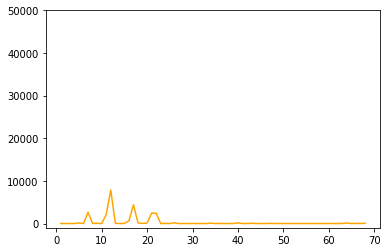

In [44]:
main_code(realExample)


Loaded GPT-2 model!
0.99 Seconds for a check with GPT-2


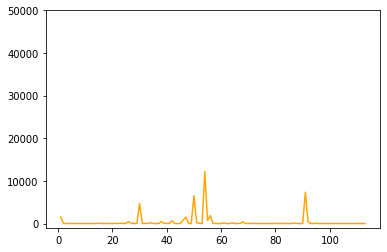

In [42]:
main_code(generatedExample)